In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics_2016.csv')
keys = ['HIOS ID','Policy County FIPS Code','IssuerId','County','State']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']


x_cols = []
for col in df.columns:
    if (col not in y_cols and col not in keys 
        and col not in missing_cols and not 'StateCode' in col and not 'IssuerId' in col):  
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

print(len(x_cols))


X = X/X.std()


for col in x_cols:
    if X[col].isna().sum() > 0:
        print(col,'na')
    if X[col].isin([np.inf, -np.inf]).sum() > 0:
        print(col)

333


In [3]:
x_cols2 = ['prices', 'FirstTierUtilization', 'BeginPrimaryCareCostSharingAfterNumberOfVisits', 'BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays', 'CSRVariationTypeOther', 'CSRVariationTypeStandard Silver On Exchange Plan', 'CSRVariationTypeStandard Silver Off Exchange Plan', 'BusinessYear_2016', 'SourceName_HIOS', 'SourceName_OPM', 'SourceName_SERFF', 'MarketCoverage_Individual', 'MarketCoverage_SHOP (Small Group)', 'DentalOnlyPlan_No', 'IsNewPlan_Existing', 'IsNewPlan_New', 'PlanType_EPO', 'PlanType_HMO', 'PlanType_Indemnity', 'PlanType_POS', 'PlanType_PPO', 'MetalLevel_Bronze', 'MetalLevel_Catastrophic', 'MetalLevel_Gold', 'QHPNonQHPTypeId_Both', 'QHPNonQHPTypeId_On the Exchange', 'CompositeRatingOffered_No', 'CompositeRatingOffered_Yes', 'ChildOnlyOffering_Allows Adult and Child-Only', 'ChildOnlyOffering_Allows Adult-Only', 'ChildOnlyOffering_Allows Child-Only', 'OutOfCountryCoverage_No', 'OutOfCountryCoverage_YES', 'OutOfCountryCoverage_Yes', 'OutOfServiceAreaCoverage_No', 'OutOfServiceAreaCoverage_YES', 'OutOfServiceAreaCoverage_Yes', 'NationalNetwork_NO', 'NationalNetwork_No', 'NationalNetwork_Yes', 'MultipleInNetworkTiers_No', 'MultipleInNetworkTiers_Yes', 'InpatientCopaymentMaximumDays_0', 'InpatientCopaymentMaximumDays_1', 'InpatientCopaymentMaximumDays_2', 'InpatientCopaymentMaximumDays_3', 'InpatientCopaymentMaximumDays_4', 'InpatientCopaymentMaximumDays_5', 'TEHBOutOfNetIndividualMOOP', 'TEHBCombInnOonFamilyPerPersonMOOP', 'TEHBInnTier1IndividualMOOP', 'SBCHavingaBabyDeductible', 'TEHBCombInnOonIndividualMOOP', 'TEHBOutOfNetFamilyPerPersonMOOP', 'TEHBInnTier1FamilyPerGroupMOOP', 'SBCHavingDiabetesDeductible', 'TEHBInnTier1FamilyPerPersonMOOP', 'SBCHavingDiabetesCoinsurance', 'SBCHavingaBabyCoinsurance', 'SBCHavingaBabyCopayment', 'TEHBCombInnOonFamilyPerGroupMOOP', 'TEHBOutOfNetFamilyPerGroupMOOP', 'SBCHavingDiabetesCopayment', 'PREMIC', 'PREMI50', 'PREMI2C30', 'PREMC2C30', 'DP03_0001PE', 'DP03_0002PE', 'DP03_0003PE', 'DP03_0004PE', 'DP03_0005PE', 'DP03_0006PE', 'DP03_0007PE', 'DP03_0008PE', 'DP03_0009PE', 'DP03_0010PE', 'DP03_0011PE', 'DP03_0012PE', 'DP03_0013PE', 'DP03_0014PE', 'DP03_0015PE', 'DP03_0016PE', 'DP03_0017PE', 'DP03_0018PE', 'DP03_0019PE', 'DP03_0020PE', 'DP03_0021PE', 'DP03_0022PE', 'DP03_0023PE', 'DP03_0024PE', 'DP03_0026PE', 'DP03_0027PE', 'DP03_0028PE', 'DP03_0029PE', 'DP03_0030PE', 'DP03_0031PE', 'DP03_0032PE', 'DP03_0033PE', 'DP03_0034PE', 'DP03_0035PE', 'DP03_0036PE', 'DP03_0037PE', 'DP03_0038PE', 'DP03_0039PE', 'DP03_0040PE', 'DP03_0041PE', 'DP03_0042PE', 'DP03_0043PE', 'DP03_0044PE', 'DP03_0045PE', 'DP03_0046PE', 'DP03_0047PE', 'DP03_0048PE', 'DP03_0049PE', 'DP03_0050PE', 'DP03_0051PE', 'DP03_0052PE', 'DP03_0053PE', 'DP03_0054PE', 'DP03_0055PE', 'DP03_0056PE', 'DP03_0057PE', 'DP03_0058PE', 'DP03_0059PE', 'DP03_0060PE', 'DP03_0061PE', 'DP03_0064PE', 'DP03_0066PE', 'DP03_0068PE', 'DP03_0070PE', 'DP03_0072PE', 'DP03_0074PE', 'DP03_0075PE', 'DP03_0076PE', 'DP03_0077PE', 'DP03_0078PE', 'DP03_0079PE', 'DP03_0080PE', 'DP03_0081PE', 'DP03_0082PE', 'DP03_0083PE', 'DP03_0084PE', 'DP03_0085PE', 'DP03_0089PE', 'DP03_0095PE', 'DP03_0096PE', 'DP03_0097PE', 'DP03_0098PE', 'DP03_0099PE', 'DP03_0100PE', 'DP03_0101PE', 'DP03_0102PE', 'DP03_0103PE', 'DP03_0104PE', 'DP03_0105PE', 'DP03_0106PE', 'DP03_0107PE', 'DP03_0108PE', 'DP03_0109PE', 'DP03_0110PE', 'DP03_0111PE', 'DP03_0112PE', 'DP03_0113PE', 'DP03_0114PE', 'DP03_0115PE', 'DP03_0116PE', 'DP03_0117PE', 'DP03_0118PE', 'DP03_0119PE', 'DP03_0120PE', 'DP03_0121PE', 'DP03_0122PE', 'DP03_0123PE', 'DP03_0124PE', 'DP03_0125PE', 'DP03_0126PE', 'DP03_0127PE', 'DP03_0128PE', 'DP03_0129PE', 'DP03_0130PE', 'DP03_0131PE', 'DP03_0132PE', 'DP03_0133PE', 'DP03_0134PE', 'DP03_0135PE', 'DP03_0136PE', 'DP03_0137PE', 'DP05_0001PE', 'DP05_0002PE', 'DP05_0003PE', 'DP05_0005PE', 'DP05_0006PE', 'DP05_0007PE', 'DP05_0008PE', 'DP05_0009PE', 'DP05_0010PE', 'DP05_0011PE', 'DP05_0012PE', 'DP05_0013PE', 'DP05_0014PE', 'DP05_0016PE', 'DP05_0019PE', 'DP05_0020PE', 'DP05_0021PE', 'DP05_0022PE', 'DP05_0023PE', 'DP05_0024PE', 'DP05_0025PE', 'DP05_0026PE', 'DP05_0027PE', 'DP05_0029PE', 'DP05_0030PE', 'DP05_0031PE', 'DP05_0033PE', 'DP05_0034PE', 'DP05_0035PE', 'DP05_0036PE', 'DP05_0037PE', 'DP05_0038PE', 'DP05_0039PE', 'DP05_0040PE', 'DP05_0041PE', 'DP05_0042PE', 'DP05_0043PE', 'DP05_0044PE', 'DP05_0045PE', 'DP05_0046PE', 'DP05_0047PE', 'DP05_0048PE', 'DP05_0049PE', 'DP05_0050PE', 'DP05_0051PE', 'DP05_0052PE', 'DP05_0053PE', 'DP05_0054PE', 'DP05_0055PE', 'DP05_0056PE', 'DP05_0057PE', 'DP05_0058PE', 'DP05_0059PE', 'DP05_0060PE', 'DP05_0061PE', 'DP05_0062PE', 'DP05_0063PE', 'DP05_0064PE', 'DP05_0065PE', 'DP05_0066PE', 'DP05_0067PE', 'DP05_0068PE', 'DP05_0070PE', 'DP05_0071PE', 'DP05_0072PE', 'DP05_0073PE', 'DP05_0074PE', 'DP05_0075PE', 'DP05_0076PE', 'DP05_0077PE', 'DP05_0078PE', 'DP05_0079PE', 'DP05_0080PE', 'DP05_0082PE', 'DP05_0083PE', 'DP05_0084PE', 'S1701_C01_001E', 'S1701_C01_002E', 'S1701_C01_003E', 'S1701_C01_004E', 'S1701_C01_005E', 'S1701_C01_006E', 'S1701_C01_007E', 'S1701_C01_008E', 'S1701_C01_009E', 'S1701_C01_010E', 'S1701_C01_011E', 'S1701_C01_012E', 'S1701_C01_013E', 'S1701_C01_014E', 'S1701_C01_015E', 'S1701_C01_016E', 'S1701_C01_018E', 'S1701_C01_019E', 'S1701_C01_020E', 'S1701_C01_021E', 'S1701_C01_022E', 'S1701_C01_023E', 'S1701_C01_024E', 'S1701_C01_025E', 'S1701_C01_026E', 'S1701_C01_027E', 'S1701_C01_028E', 'S1701_C01_029E', 'S1701_C01_030E', 'S1701_C01_031E', 'S1701_C01_032E', 'S1701_C01_033E', 'S1701_C01_034E', 'S1701_C01_035E', 'S1701_C01_036E', 'S1701_C01_037E', 'S1701_C01_038E', 'S1701_C01_039E', 'S1701_C01_040E', 'S1701_C01_041E', 'S1701_C01_042E', 'S1701_C01_043E', 'S1701_C01_044E', 'S1701_C01_045E', 'S1701_C01_046E', 'S1701_C01_047E', 'S1701_C01_048E', 'S1701_C01_049E', 'S1701_C01_050E', 'S1701_C01_051E', 'S1701_C01_052E', 'S1701_C01_053E', 'S1701_C01_054E', 'S1701_C01_055E', 'S1701_C01_056E', 'S1701_C01_057E', 'S1701_C01_058E', 'S1701_C01_059E', 'S1701_C01_060E', 'S1701_C01_061E']
x_cols2 = x_cols2 + ['act_value', 'MetalLevel_Platinum', 'MetalLevel_Silver', 'Plan Counts', 'EHBPercentTotalPremium', 'DP05_0015PE', 'DP05_0069PE', 'S1701_C01_017E', 'StateCodeFL', 'DP03_0095E']

for col in x_cols2:
    if col not in x_cols:
        print(col)
print('---')
for col in x_cols:
    if col not in x_cols2:
        print(col)

prices
StateCodeFL
---
PREMI27


In [4]:
num_trials = 5
training_test = []

#initilize folds
kf = KFold(n_splits=num_trials,shuffle=True)
folds_indexes = kf.split(y)

for fold_index in folds_indexes:
    X_train, y_train = sm.add_constant(X).iloc[fold_index[0]], y.iloc[fold_index[0]]
    X_test, y_test = sm.add_constant(X).iloc[fold_index[1]], y.iloc[fold_index[1]]
    training_test.append( (X_train, X_test, y_train, y_test) )

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [5]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_test > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

------------------
mse normalized trial  0 : r2 0.27057001269869074
training 1103.7049366908523 predicted share 1122.212646484375 actual 1201.5494880546075
------------------
------------------
mse normalized trial  1 : r2 -2.018606223779182
training 1156.9652866695121 predicted share 1214.5208740234375 actual 988.5989761092151
------------------
------------------
mse normalized trial  2 : r2 0.5309838895242662
training 1118.6918918918918 predicted share 1083.002685546875 actual 1141.6402959590212
------------------
------------------
mse normalized trial  3 : r2 0.06564609881973871
training 1137.4001422475108 predicted share 1203.725341796875 actual 1066.785998861696
------------------
------------------
mse normalized trial  4 : r2 0.1723096405765282
training 1099.6423897581792 predicted share 1125.923828125 actual 1217.8599886169607
------------------


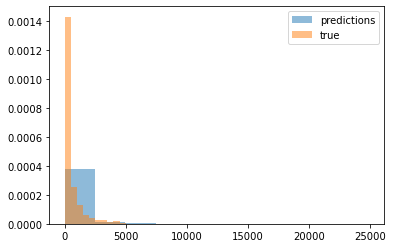

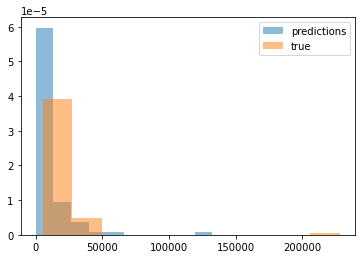

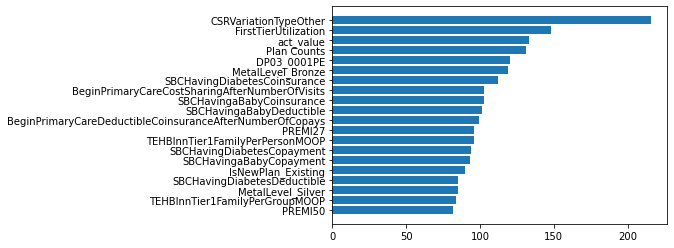

mse 21471270.6439031 r2 0.05608773808331158
mse med 25206001.979682315 r2 med 0.27057001269869074


In [6]:
params = [(5,.1,.5,.3)]
#(2,.2,.5,.9)
#(2,.5,.9,.9),(5,.5, 0.5, .9),

for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[i]
        # not super deep, but uses most of the data at one
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)
        mse = float( ((y_test - y_pred)**2).mean() )
        r2 = float(  1- mse/y_test.var() )
        print('------------------')
        print('mse normalized trial ', i,': r2', r2)#, mse, float(true_shares.var()) )
        print('training', float(y_train.mean()) ,
          'predicted share', float(y_pred.mean()) ,'actual', float(y_test.mean()))
        print('------------------')
            
        mses.append(mse)
        r2s.append(r2)

        #plot the difference between true and predicted
        if i == num_trials -1:
            split = 5000
            plot_prediction(split,y_pred,y_test)
            plot_importance(X_test,model)
            
    #report fit statistics
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', np.array(mses).mean() ,'r2', 1 - float(np.array(mses).mean()/y.var()) )
    print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )

------------------
mse normalized trial  0 : r2 0.26502081813201617
training 1103.7049366908523 predicted share 1104.5100466995702 actual 1201.5494880546075
------------------
------------------
mse normalized trial  1 : r2 -0.3914605348869653
training 1156.9652866695121 predicted share 1103.899409013907 actual 988.5989761092151
------------------
------------------
mse normalized trial  2 : r2 0.3646217388149491
training 1118.6918918918918 predicted share 1166.1919064192641 actual 1141.6402959590212
------------------
------------------
mse normalized trial  3 : r2 0.3234924368983164
training 1137.4001422475108 predicted share 1201.615988579282 actual 1066.785998861696
------------------
------------------
mse normalized trial  4 : r2 0.2364352259103344
training 1099.6423897581792 predicted share 1061.109657747604 actual 1217.8599886169607
------------------


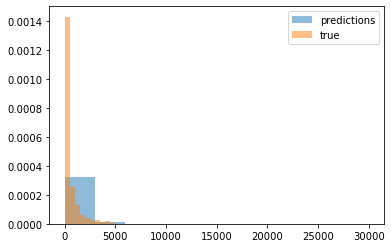

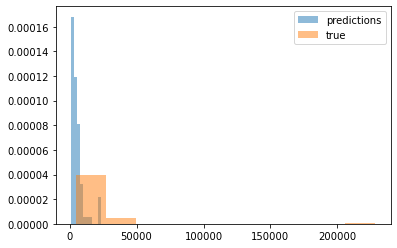

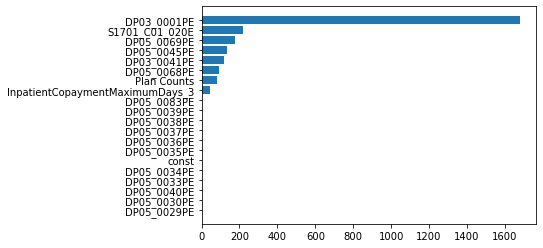

mse trial 4 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     23717.925189         10425.000000           NaN           NaN
IL     18004.584492         20244.000000  16987.964589  22255.478831
NV     12575.661942          5267.000000           NaN           NaN
TX     10020.000449         13359.333333   3659.795769  13655.536396
MI      9657.780809          1517.000000     71.154757    890.954544
FL      9193.013342         42834.800000   8280.673393  66211.668944
OH      7381.201137          1269.500000      0.000000    294.863528
PA      6012.723911         18180.000000   1693.941903  14700.425459
0       5150.258007         16959.833333   1513.544381   4760.051404
WI      4840.449570          5267.000000   1826.605077   6861.764205
MO      3456.405872         12213.000000   1248.271280   5873.228925
UT      3226.719871         18876.000000   2197.502651  10718.123623
TN      3198.124845 

In [7]:
# Vary alpha values
a = [250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[j]
        
        lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test)

        mse = float(((y_test - y_pred)**2).mean())
        r2 = float( 1 - mse/y_test.var() )
        print('------------------')
        print('mse normalized trial ', j,': r2', r2)#, mse, float(true_shares.var()) )
        print('training', float(y_train.mean()) ,
          'predicted share', float(y_pred.mean()) ,'actual', float(y_test.mean()))
        print('------------------')
        mses.append(mse)
        r2s.append(r2)
        

        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,y_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print('mse trial', j, ':',report_error(y_test,y_pred))

    print('alpha_value:', i)
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', np.array(mses).mean() ,'r2', 1 - float(np.array(mses).mean()/y.var()) )
    print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )
    print('==========================================')
    print('==========================================')

In [8]:
#some training sets total number of consumers?
#some times DP03_CSR?